Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [4]:
print(words[0:100])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']


Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print(reverse_dictionary[data[0]])
print("count:",count[:10])
print(len(data))
#del words  # Hint to reduce memory.


Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5240, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
anarchism
count: [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
17005207


Function to generate a training batch for the skip-gram model.

In [23]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  #assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=len(data), num_skips=num_skips, skip_window=skip_window)
    print(labels.shape)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch text:', [reverse_dictionary[bi] for bi in batch[:8]])
    print('    labels text:', [reverse_dictionary[li] for li in labels[:8].reshape(8)])
    print('    batch :', batch[:8])
    print('    labels :', labels[:8])

# for num_skips, skip_window in [(2, 1), (4, 2)]:
#     data_index = 0
#     batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
#     print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
#     print('    batch:', [reverse_dictionary[bi] for bi in batch])
#     print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
(17005207, 1)

with num_skips = 2 and skip_window = 1:
    batch text: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels text: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'of', 'a']
    batch : [3084 3084   12   12    6    6  195  195]
    labels : [[5240]
 [  12]
 [3084]
 [   6]
 [ 195]
 [  12]
 [   2]
 [   6]]


Train a skip-gram model.

In [7]:
#trainigSet,trainingLabels = generate_batch(batch_size=len(data), num_skips=2, skip_window=1)


[[6], [28], [4], [2], [9], [3], [63], [20], [5], [27], [24], [25], [52], [40], [15], [1], [46], [3], [1], [30], [8], [11], [1], [38], [45], [3], [1], [37], [8], [36], [1], [9], [7], [58], [5], [23], [2], [42], [72], [12], [66], [67], [43], [13], [5], [68], [26], [12], [33], [1], [65], [3], [56], [34], [69], [16], [17], [44], [49], [4], [2], [19], [62], [14], [61], [18], [21], [1], [47], [6], [7], [32], [57], [1], [70], [35], [71], [41], [55], [54], [6], [4], [2], [48], [31], [7], [1], [60], [13], [51], [10], [22], [11], [29], [50], [53], [59], [64], [10], [39]]


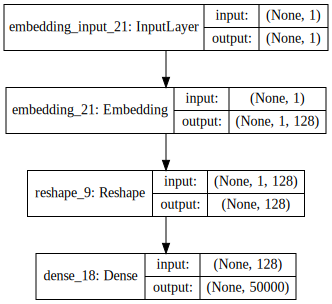

In [37]:
#print(trainingLabels[:8].reshape(8,))

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
#print(words[:100])
tokenizer.fit_on_texts(words[:100])
#print(tokenizer.word_index)

#print(len(tokenizer.word_index))
squence = tokenizer.texts_to_sequences(words[:100])
print(squence)
#print(tokenizer.word_counts)

batch_size=8


embedding_size = 128
V = len(tokenizer.word_index)+1
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Dense, Embedding, Reshape
from keras.models import Sequential
from keras.utils.visualize_util import model_to_dot, plot
from IPython.display import SVG


skipgram = Sequential()
#skipgram.add(Dense(output_dim=vocabulary_size,input_dim=1))
#skipgram.add(Dense(embedding_size))




skipgram.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, init='glorot_uniform', input_length=1))
skipgram.add(Reshape((embedding_size,)))
skipgram.add(Dense(output_dim=vocabulary_size, activation='softmax'))
SVG(model_to_dot(skipgram, show_shapes=True).create(prog='dot', format='svg'))




In [63]:
skipgram.compile(loss='categorical_crossentropy', optimizer="adadelta")

def labelToOneHot(s,num_classes):
    return (np.array(s)[:,None]==np.arange(num_classes))+0

for ite in range(500000):
    loss = 0.
    batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
    x = batch.reshape(-1)
    y = labels.reshape(len(labels))
    onehotY = labelToOneHot(y,vocabulary_size)   
    loss += skipgram.train_on_batch(x, onehotY)
    if(ite%1000==0):
        print(ite, loss)

0 9.92317390442
1000 9.95869827271
2000 8.07407569885
3000 10.6062917709
4000 9.01307106018
5000 4.53939342499
6000 8.97358894348
7000 6.75835609436
8000 10.3953838348
9000 10.2200984955
10000 9.73827552795
11000 9.38654232025
12000 5.55086517334
13000 5.21680259705
14000 7.8985414505
15000 10.3087844849
16000 8.16814613342
17000 5.42658615112
18000 10.8131809235
19000 9.05113220215
20000 10.7782487869
21000 9.34317207336
22000 4.85680913925
23000 3.17494726181
24000 8.90252685547
25000 10.3010702133
26000 10.3195075989
27000 7.24621295929
28000 8.49403572083
29000 9.98687934875
30000 9.35484027863
31000 8.37885093689
32000 9.7948513031
33000 10.4576292038
34000 7.5298166275
35000 9.39340496063
36000 8.15675163269
37000 6.02744150162
38000 4.15941905975
39000 6.84195995331
40000 6.34316110611
41000 9.16511917114
42000 8.68989944458
43000 8.78167915344
44000 9.26678466797
45000 8.32083702087
46000 9.69190979004
47000 8.28734302521
48000 8.75452709198
49000 9.68467998505
50000 7.57075929

[('europe', 0.8799024820327759),
 ('france', 0.8566158413887024),
 ('italy', 0.8444074392318726),
 ('afghanistan', 0.8344353437423706),
 ('interest', 0.8229002952575684),
 ('rome', 0.8073470592498779),
 ('china', 0.8064821362495422),
 ('scotland', 0.8057228326797485),
 ('sweden', 0.8041954636573792),
 ('turn', 0.7972730398178101)]

In [55]:
from gensim.models.doc2vec import Word2Vec
vectors = skipgram.get_weights()[0]
print(vectors.shape)

f = open('vectors.txt' ,'w')
f.write(" ".join([str(vocabulary_size-1),str(embedding_size)]))
f.write("\n")

print("total words:",len(count[1:]))
loopIndex = 0
for (index,atuple) in enumerate(count[1:]):
    i=index+1
    f.write(reverse_dictionary[i])
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
    loopIndex+=1
    if(loopIndex%500==0):
        print(loopIndex)
f.close()
print("writing file finshed")

(50000, 128)
total words: 49999
1 ('the', 1061396)
word===> the
2 ('of', 593677)
word===> of
3 ('and', 416629)
word===> and
4 ('one', 411764)
word===> one
5 ('in', 372201)
word===> in
6 ('a', 325873)
word===> a
7 ('to', 316376)
word===> to
8 ('zero', 264975)
word===> zero
9 ('nine', 250430)
word===> nine
10 ('two', 192644)
word===> two
11 ('is', 183153)
word===> is
12 ('as', 131815)
word===> as
13 ('eight', 125285)
word===> eight
14 ('for', 118445)
word===> for
15 ('s', 116710)
word===> s
16 ('five', 115789)
word===> five
17 ('three', 114775)
word===> three
18 ('was', 112807)
word===> was
19 ('by', 111831)
word===> by
20 ('that', 109510)
word===> that
21 ('four', 108182)
word===> four
22 ('six', 102145)
word===> six
23 ('seven', 99683)
word===> seven
24 ('with', 95603)
word===> with
25 ('on', 91250)
word===> on
26 ('are', 76527)
word===> are
27 ('it', 73334)
word===> it
28 ('from', 72871)
word===> from
29 ('or', 68945)
word===> or
30 ('his', 62603)
word===> his
31 ('an', 61925)
word===

In [66]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)
w2v.most_similar(positive=['can'])

[('may', 0.9297199249267578),
 ('should', 0.9104194641113281),
 ('could', 0.887963056564331),
 ('would', 0.8817561864852905),
 ('must', 0.8282632827758789),
 ('will', 0.7964667081832886),
 ('to', 0.7844716906547546),
 ('might', 0.7595037221908569),
 ('cannot', 0.7499113082885742),
 ('noted', 0.6757275462150574)]

In [8]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print(embed)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
  print(similarity)

Tensor("embedding_lookup:0", shape=(128, 128), dtype=float32, device=/device:CPU:0)
Tensor("MatMul:0", shape=(16, 50000), dtype=float32, device=/device:CPU:0)


In [13]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.949860
Nearest to the: sinks, implementing, casualty, mortar, fighter, lund, forced, cointelpro,
Nearest to first: seabed, paula, lepidus, kreutzmann, tiryns, spheroidal, elaboration, essence,
Nearest to have: surpassed, pilots, messerschmitt, wider, logged, barre, compliment, tantamount,
Nearest to these: militias, vue, barbarous, ladyland, schama, transference, glimpse, cofinality,
Nearest to its: bowie, does, fiercest, denslow, monosyllabic, gauss, sidemen, boundless,
Nearest to will: freitas, infringe, fixation, skewed, billet, bryson, salaam, militaristic,
Nearest to after: melito, moldovan, gutnish, petrarch, securely, euler, accident, tart,
Nearest to which: colorless, disobeyed, stereochemistry, rec, capacity, persisting, diggers, colonial,
Nearest to to: competitions, forbids, twisted, czechs, application, cena, relational, terrell,
Nearest to s: tobias, undulating, mo, donatello, immanence, aslan, christie, barracuda,
Nearest to would: mo

KeyboardInterrupt: 

In [10]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

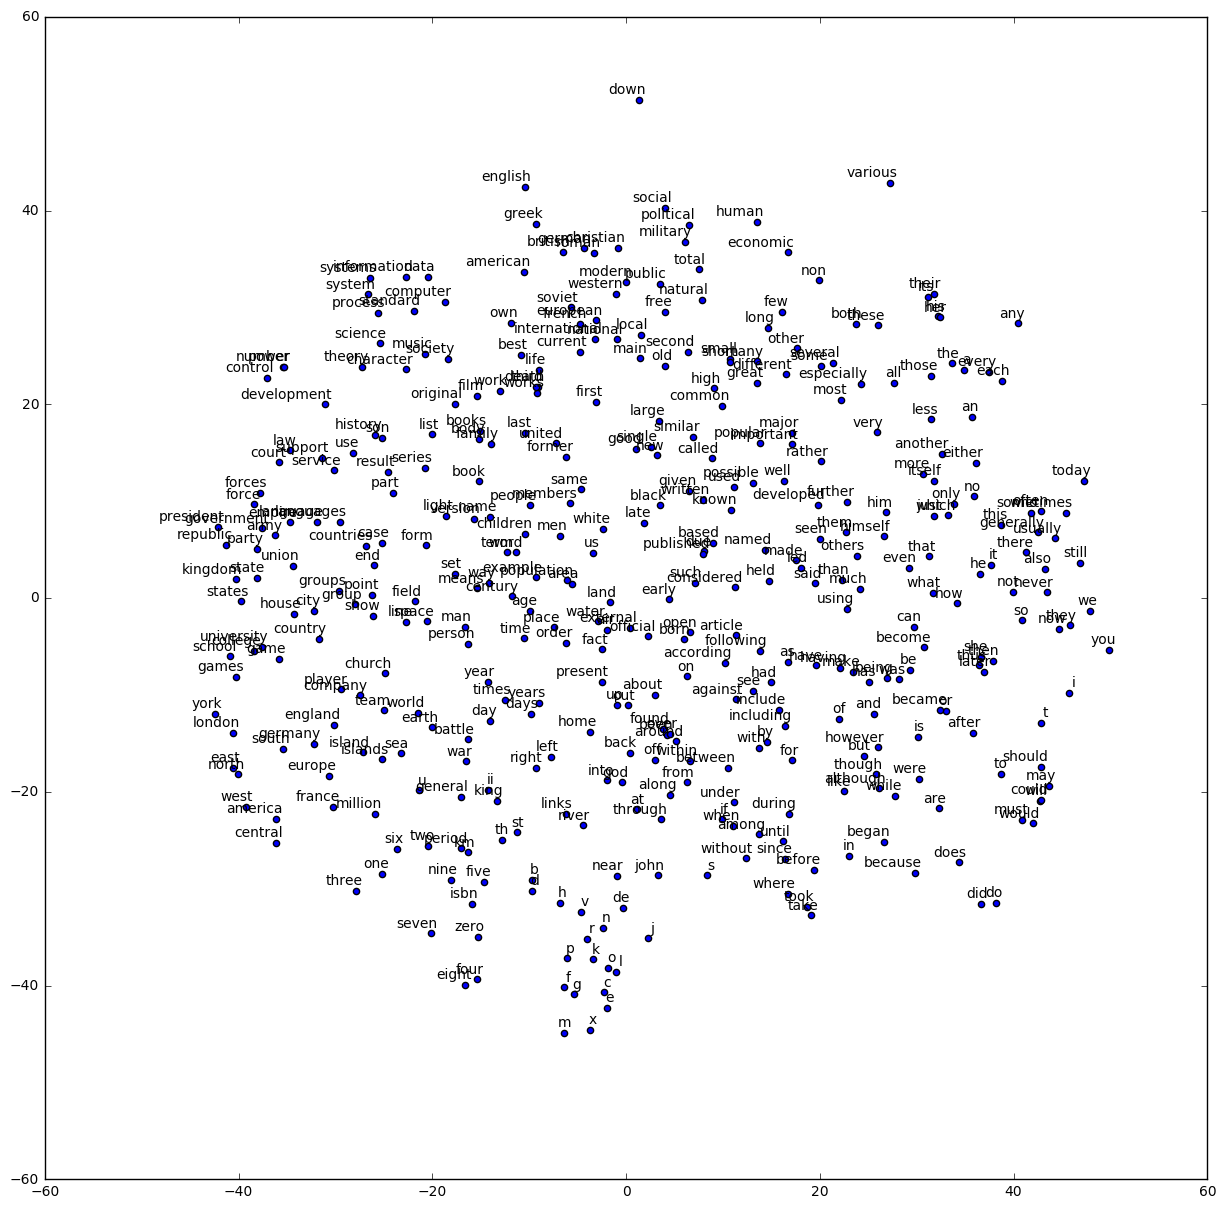

In [11]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size,skip_window*2), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for i in range(batch_size):
        for j in range(span):
            buffer.append(data[(data_index+j)% len(data)])
        data_index = (data_index + 1) % len(data)
        centerIndex = (span+1)//2-1
        labels[i,0] = buffer[centerIndex]
        buffer.remove(buffer[centerIndex])
        train = list(buffer)
        #print('    batch:', [reverse_dictionary[bi] for bi in train])
        #print('    label:', reverse_dictionary[labels[i,0]] )
        batch[i] = train

  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    #print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])  
    #print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])  
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and skip_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [7]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*skip_window])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print(embed)
  print(tf.reduce_sum(embed, 1))
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, tf.reduce_sum(embed, 1), # 相当于把两个index的值加起来，什么鬼，不会丢失吗？
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
  print(similarity)

Tensor("embedding_lookup:0", shape=(128, 2, 128), dtype=float32, device=/device:CPU:0)
Tensor("Sum:0", shape=(128, 128), dtype=float32, device=/device:CPU:0)
Tensor("MatMul:0", shape=(16, 50000), dtype=float32, device=/device:CPU:0)


In [8]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.709158
Nearest to or: adequate, plaintexts, archbishopric, louis, tynwald, denunciation, ergo, unknown,
Nearest to the: mesh, coprocessor, sixty, monsters, zoe, elihu, restarted, cannonball,
Nearest to not: perilous, brave, solver, sprague, parlor, wilkinson, lorentz, genteel,
Nearest to world: carmack, blistering, dvorak, fluke, matth, realise, transponder, dutch,
Nearest to is: physica, ndnis, hennecke, ascendancy, klister, hernando, stripped, vineyards,
Nearest to for: faramir, rusher, drake, credentials, palpitations, lighthouse, italics, encourage,
Nearest to after: dixie, leveraged, ketchup, kipling, sadc, contractual, mesh, hagelin,
Nearest to up: meager, falla, gilmore, nad, mosiah, karst, disgraceful, retained,
Nearest to that: discriminatory, transactional, weathering, genocide, jeff, kobe, constellations, frankish,
Nearest to while: situs, selectivity, richthofen, october, followers, landes, lowe, cabaret,
Nearest to however: excitement,

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

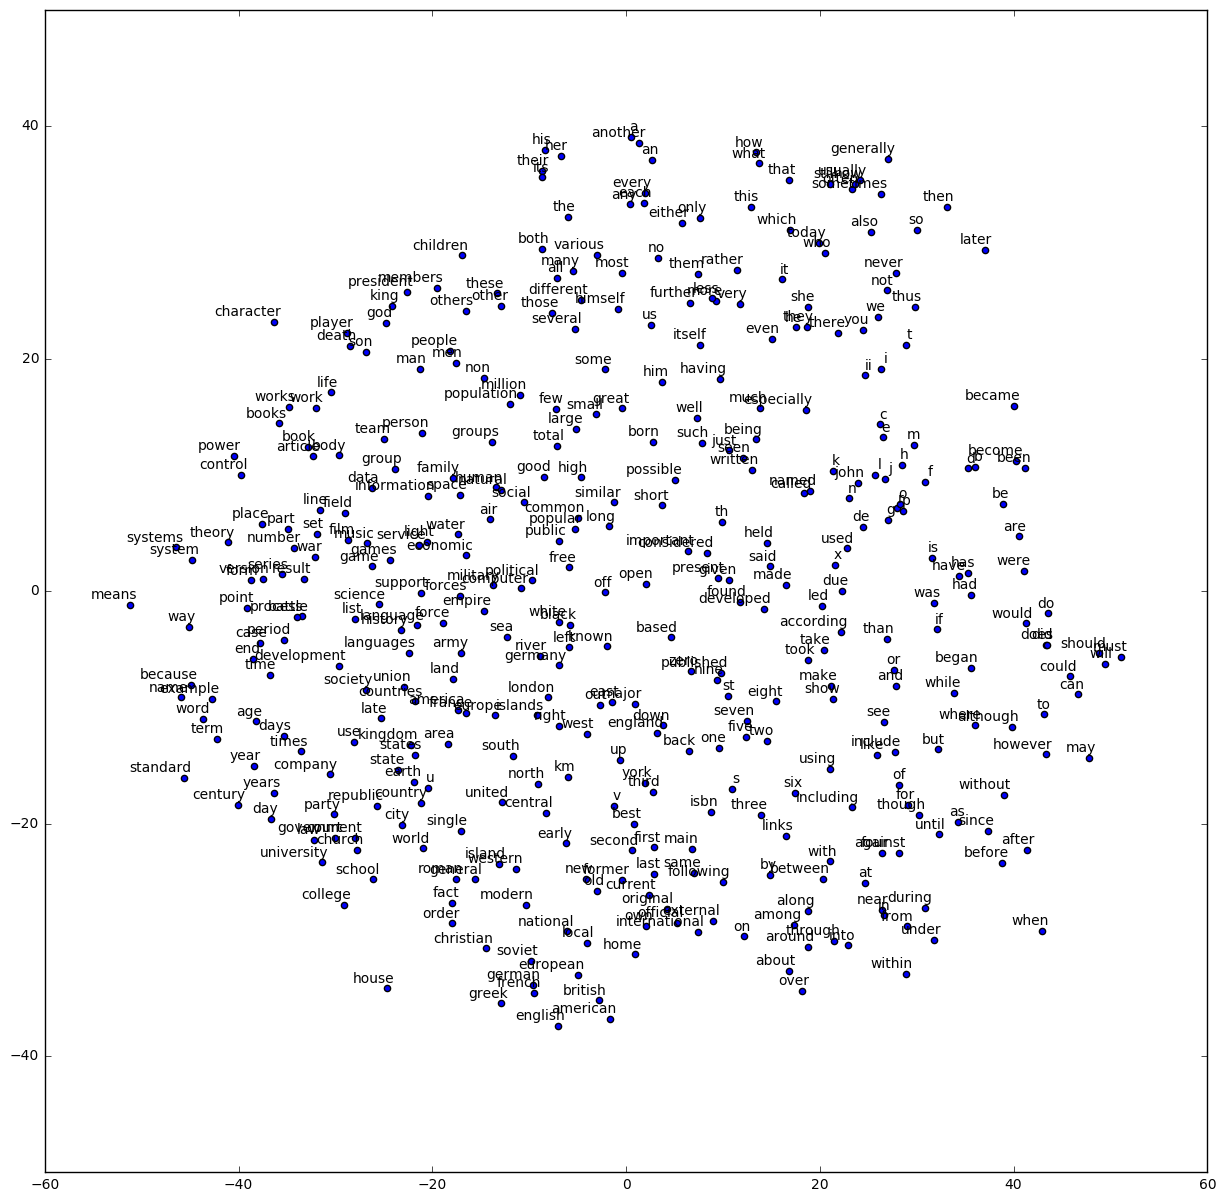

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)